In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from inpainting.visualizations import samples as vis
from inpainting.visualizations.digits import digit_with_mask as vis_digit_mask
import pandas as pd
from inpainting.evaluation import evaluation as ev
from tqdm import tqdm
from itertools import chain
from inpainting.evaluation.frechet_models import MNISTNet
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from inpainting.evaluation import fid
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

In [5]:
experiments_paths = {
    "gmm": Path("../results/celeba/default/")
}

In [6]:
experiments_results = dict()

for (name, path) in experiments_paths.items():
    with (path / "val_predictions.pkl").open("rb") as f:
        experiments_results[name] = pickle.load(f)

In [15]:
experiments_images = dict()

for (name, results) in experiments_results.items():
    experiments_images[name] = [(ev.outputs_to_images(*r), None) for r in results]

# Skimage metrics

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

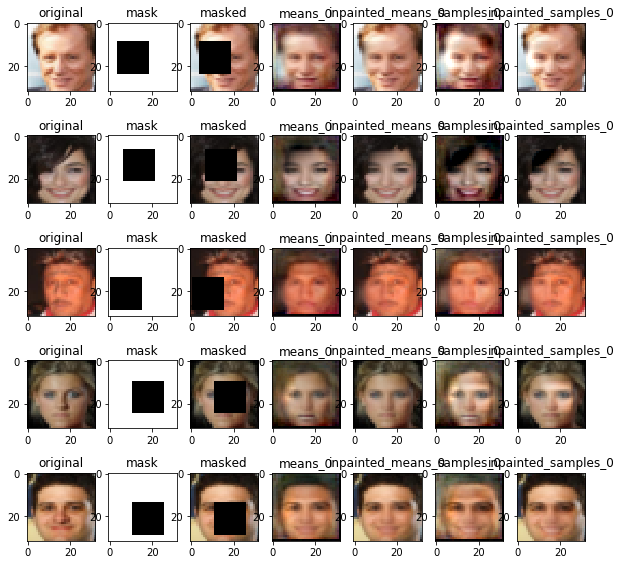

In [16]:
def plot_exp_images(images_dicts, figsize=(15,15)):
    width = len(images_dicts[0][0])
    height = len(images_dicts)
    fig, ax = plt.subplots(height,width, figsize=figsize)
    for i, (imgs, label) in enumerate(images_dicts):
        for j, (k, v) in enumerate(imgs.items()):
            ax[i][j].imshow(v)
            ax[i][j].set_title(k)

plot_exp_images(experiments_images["gmm"][:5], figsize=(10,10))

In [17]:
experiments_metrics = {
    name: [
        {
            "metrics": ev.images_metrics(img_dict),
            "label": label
        }
        for (img_dict, label) in tqdm(img_dicts)
    ]
    for name, img_dicts in experiments_images.items()
}

  0%|          | 0/19867 [00:00<?, ?it/s]/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
../inpainting/evaluation/evaluation.py:82: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  "peak_signal_noise_ratio": lambda i1, i2,: peak_signal_noise_ratio(i1, i2)
100%|██████████| 19867/19867 [03:09<00:00, 104.84it/s]


In [18]:
per_image_metrics_df = pd.DataFrame([
    {
        "imputer_model": model,
        "label": label_metric["label"],
        **metric
    }
    for model, label_metrics in experiments_metrics.items()
    for label_metric in label_metrics
    for metric in label_metric["metrics"]
])
per_image_metrics_df

,imputer_model,label,img_kind,structural_similarity,peak_signal_noise_ratio
0,gmm,None,original,1.000000,inf
1,gmm,None,mask,0.083127,5.141245
2,gmm,None,masked,0.478671,9.172607
3,gmm,None,means_0,0.750966,13.125717
4,gmm,None,inpainted_means_0,0.950512,27.219470
...,...,...,...,...,...
139064,gmm,None,masked,0.609967,10.303406
139065,gmm,None,means_0,0.579605,9.479812
139066,gmm,None,inpainted_means_0,0.941068,26.777590
139067,gmm,None,samples_0,0.483122,8.004573


In [13]:
per_image_metrics_df.groupby(["imputer_model", "img_kind"]).agg(["mean", "std"])

structural_similarity            \
                                                   mean       std   
imputer_model img_kind                                              
gmm           inpainted_means_0                0.932527  0.039070   
              inpainted_samples_0              0.890300  0.058138   
              mask                             0.070238  0.063929   
              masked                           0.563183  0.085264   
              means_0                          0.708522  0.083882   
              original                         1.000000  0.000000   
              samples_0                        0.618063  0.115744   

                                  peak_signal_noise_ratio            
                                                     mean       std  
imputer_model img_kind                                               
gmm           inpainted_means_0                 27.396420  3.608173  
              inpainted_samples_0               24.019277  3.843533  
              mask                               4.316770  1.079405  
              masked                            12.138445  2.113584  
              means_0                           14.828868  2.284920  
              original                                inf       NaN  
              samples_0                         13.728807  2.224265

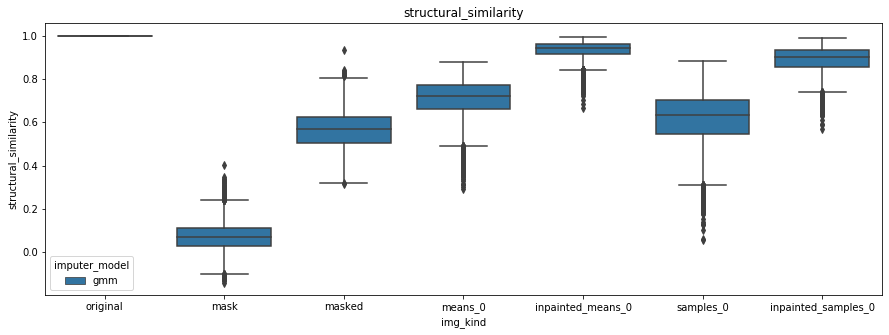

/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/numpy/lib/function_base.py:3949: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1291: RuntimeWarning: invalid value encountered in double_scalars
  stats['iqr'] = q3 - q1
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]


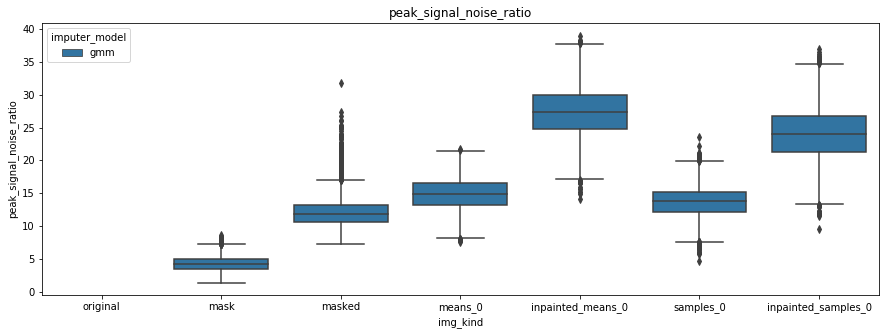

In [14]:
for metric in ["structural_similarity", "peak_signal_noise_ratio"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=per_image_metrics_df,
        y=metric,
        x="img_kind",
        hue="imputer_model"
    )
    plt.show()

# Frechet distance

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ds_train = MNIST(Path.home() / "uj" / "data", train=True, download=True, transform=ToTensor())
ds_val = MNIST(Path.home() / "uj" / "data", train=False, download=True, transform=ToTensor())

dl_train = DataLoader(ds_train, 256, shuffle=True)
dl_val = DataLoader(ds_val, 256, shuffle=False)

classifier = MNISTNet()
opt = Adam(classifier.parameters(), 4e-3)
loss_fn = CrossEntropyLoss()

classifier.to(device)
for i in range(5):
    classifier.train()
    for X, y in tqdm(dl_train):
        opt.zero_grad()
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
    classifier.eval()
    accs = []
    for (X,y ) in dl_val:
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        logits = y_pred.argmax(1)
        accs.append(accuracy_score(y.cpu().numpy(), logits.cpu().numpy()))
    print(i, np.mean(accs))

  0%|          | 0/235 [00:00<?, ?it/s]

cuda


  1%|          | 2/235 [00:00<00:14, 15.58it/s]

0 0.97646484375


  1%|▏         | 3/235 [00:00<00:10, 21.38it/s]

1 0.982421875


  1%|          | 2/235 [00:00<00:12, 18.44it/s]

2 0.9833984375


  1%|          | 2/235 [00:00<00:12, 18.19it/s]

3 0.98623046875


100%|██████████| 235/235 [00:07<00:00, 31.24it/s]


4 0.98603515625


In [56]:
def images_loader(
    images,
    batch_size = 256
):
    return DataLoader(
        TensorDataset(
            torch.Tensor([
                img.transpose(2, 0, 1)
                for img in images
            ])
        ),
        batch_size=batch_size
    )
    

def frechet_distance(
    images_loader_1,
    images_loader_2,
    model=classifier
):
    (mu_1, s_1), (mu_2, s_2) = [
        fid.calculate_activation_statistics(
            il,
            len(il.dataset),
            model,
            feature_dim=128,
        )
        for il in [images_loader_1, images_loader_2]
    ]
    return fid.calculate_frechet_distance(
        mu_1, s_1, mu_2, s_2
    )

def grouped_by_kinds(images_dicts):
    return {
        k: [
            i_d[k] for (i_d, _) in images_dicts
        ]
        for k in images_dicts[0][0].keys()
    }
    


In [57]:
experiments_images_by_kinds = {
    name: grouped_by_kinds(img_dicts)
    for name, img_dicts in experiments_images.items()
}

In [58]:
frechet_dists = {
    name: {
        kind: frechet_distance(
            images_loader(kind_to_images["original"]),
            images_loader(images)
            )
        for kind, images in kind_to_images.items()
    }
    for name, kind_to_images in experiments_images_by_kinds.items()
}

In [59]:
frechet_dists_df = pd.DataFrame([
    {
        "imputer_model": name,
        "kind": kind,
        "frechet_distance": fd
    }
    for name, kind_to_fd in frechet_dists.items()
    for kind, fd in kind_to_fd.items()
])

frechet_dists_df

,imputer_model,kind,frechet_distance
0,misgan,original,0.000000e+00
1,misgan,mask,3.711786e+01
2,misgan,masked,1.227900e+01
3,misgan,means_0,4.105498e+00
4,misgan,inpainted_means_0,1.388230e+00
5,misgan,samples_0,4.105498e+00
6,misgan,inpainted_samples_0,1.388230e+00
7,gmm,original,1.421085e-14
8,gmm,mask,3.717043e+01
9,gmm,masked,1.228313e+01


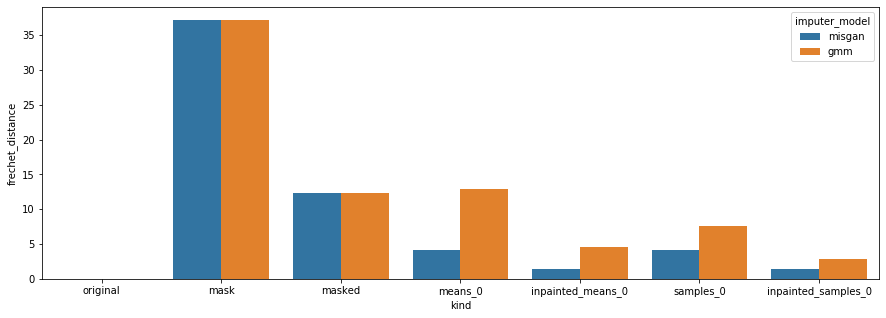

In [68]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data=frechet_dists_df,
    y="frechet_distance",
    x="kind",
    hue="imputer_model",
)